# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import objective_functions

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Przykładowe problemy testowe

In [2]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [3]:
def plot_contour_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(9, 9))
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    plt.contour(X, Y, Z, 50)
    plt.title(title)
    plt.show()

## Przykładowe modele mutacji

In [4]:
N = 250
d = 2
objective_function = objective_functions.F1a
original_individual = np.array([[1, 1]])

### Przykład 1:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma^2)$, zaś $\sigma$ jest taka sama dla wszystkich $i = 1, 2, \ldots, d$

In [5]:
sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)

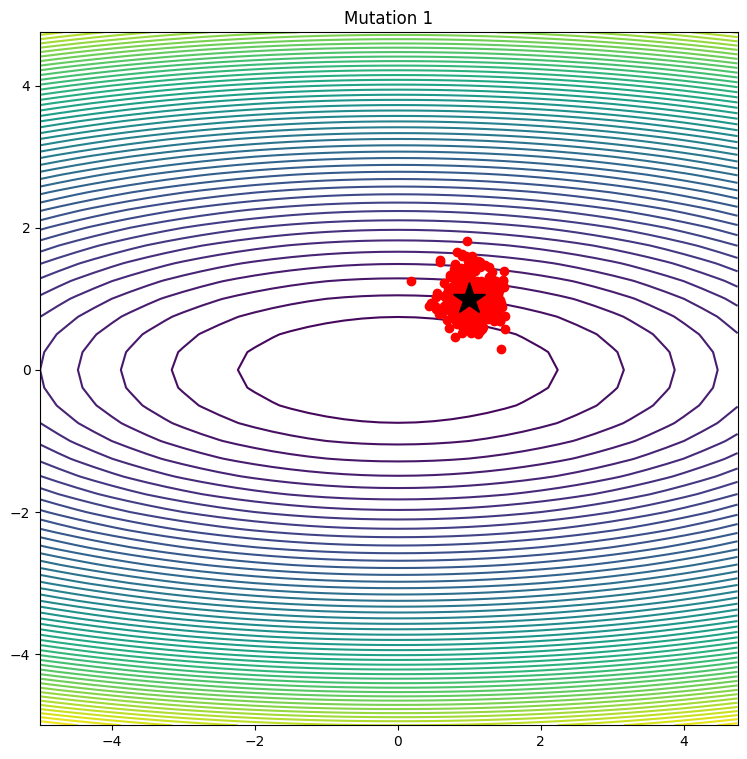

In [6]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 1')
plt.show()

### Przykład 2:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma_i^2)$, zaś $\sigma_i$ może być różna dla różnych $i = 1, 2, \ldots, d$

In [7]:
sigma = np.array([0.25, 0.5])
mutations = original_individual + sigma * np.random.randn(N, d)

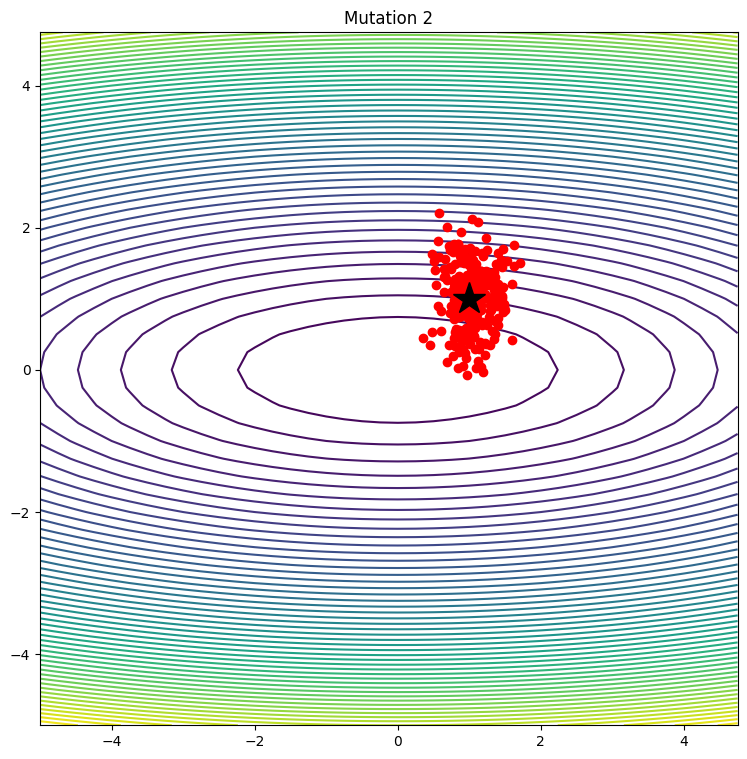

In [8]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 2')
plt.show()

### PrzykĹad 3:

$\mathbf{x} = \mathbf{x} + \boldsymbol{\varepsilon}$, gdzie $\boldsymbol{\varepsilon}$ ma wielowymiarowy rozkład normalny $\mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$

In [9]:
S = np.array([[0.25, 0.25], [0.25, 0.5]])
mutations = original_individual + (np.random.randn(N, d) @ np.linalg.cholesky(S).T)

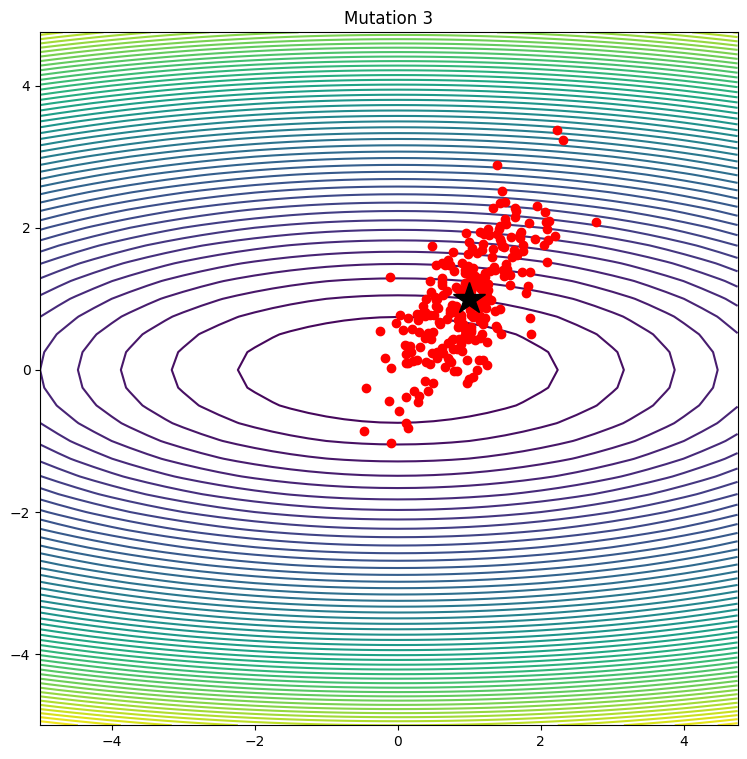

In [10]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 3')
plt.show()

## Przykładowa strategia ewolucyjna

In [11]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1

Iteration 0000 : best score = -5135.24322835, mean score = -26230.04673943.
Iteration 0010 : best score = -37.66728231, mean score = -228.21931271.
Iteration 0020 : best score = -0.06494672, mean score = -0.70124077.
Iteration 0030 : best score = -0.00035001, mean score = -0.00165715.
Iteration 0040 : best score = -0.00000057, mean score = -0.00000372.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


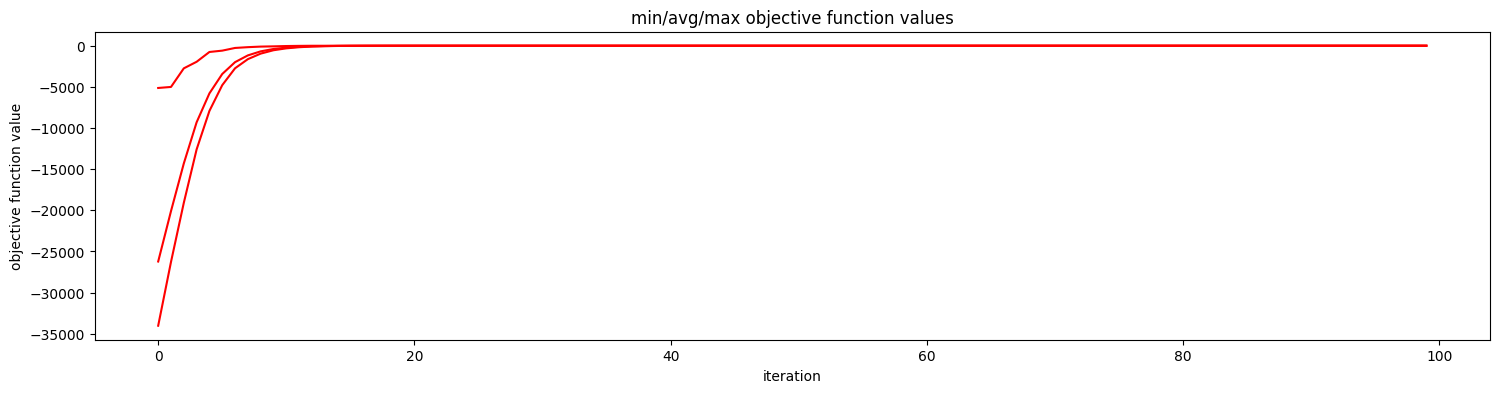

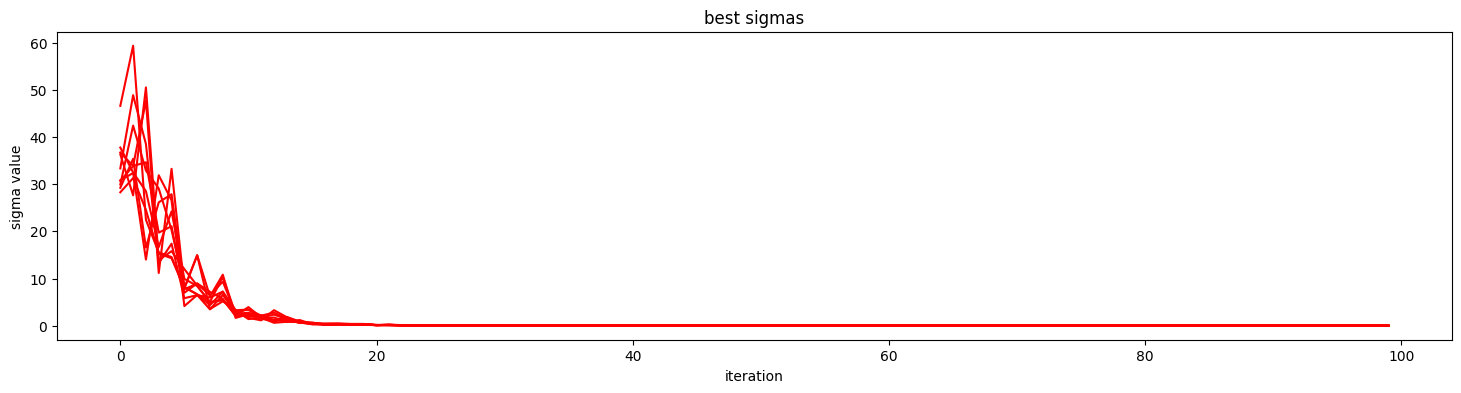

In [12]:
d = 10
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_functions.F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji Rastrigina F6

Iteration 0000 : best score = -4043.93621584, mean score = -26844.16623283.
Iteration 0010 : best score = -95.35922798, mean score = -303.11135999.
Iteration 0020 : best score = -27.79564227, mean score = -74.54330760.
Iteration 0030 : best score = -21.86990090, mean score = -60.57132578.
Iteration 0040 : best score = -12.44302440, mean score = -54.50082599.
Iteration 0050 : best score = -12.44302440, mean score = -49.96418671.
Iteration 0060 : best score = -0.59451698, mean score = -3.26895178.
Iteration 0070 : best score = -0.00199489, mean score = -0.00978789.
Iteration 0080 : best score = -0.00000308, mean score = -0.00002488.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000005.


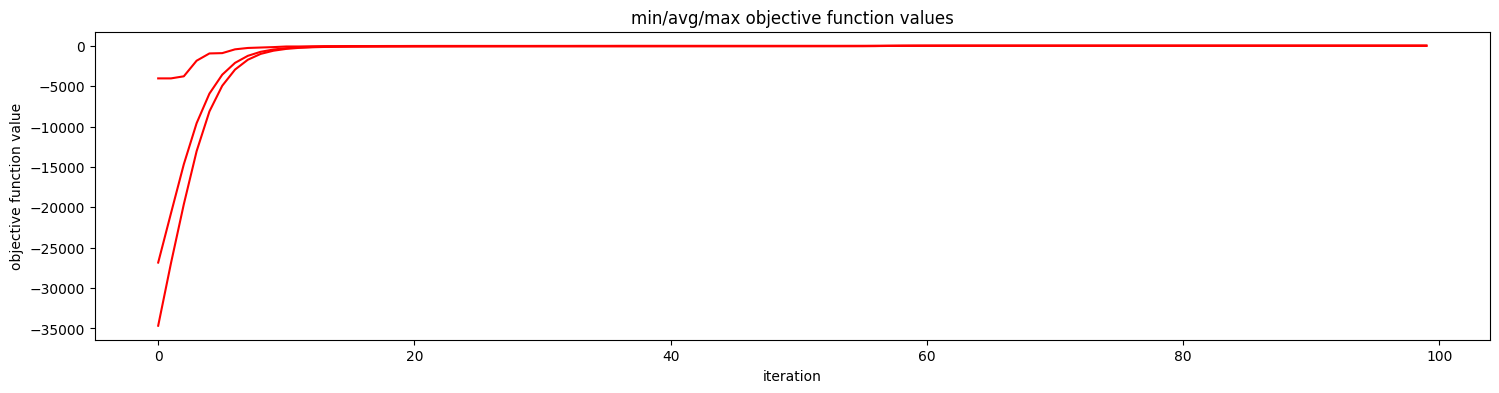

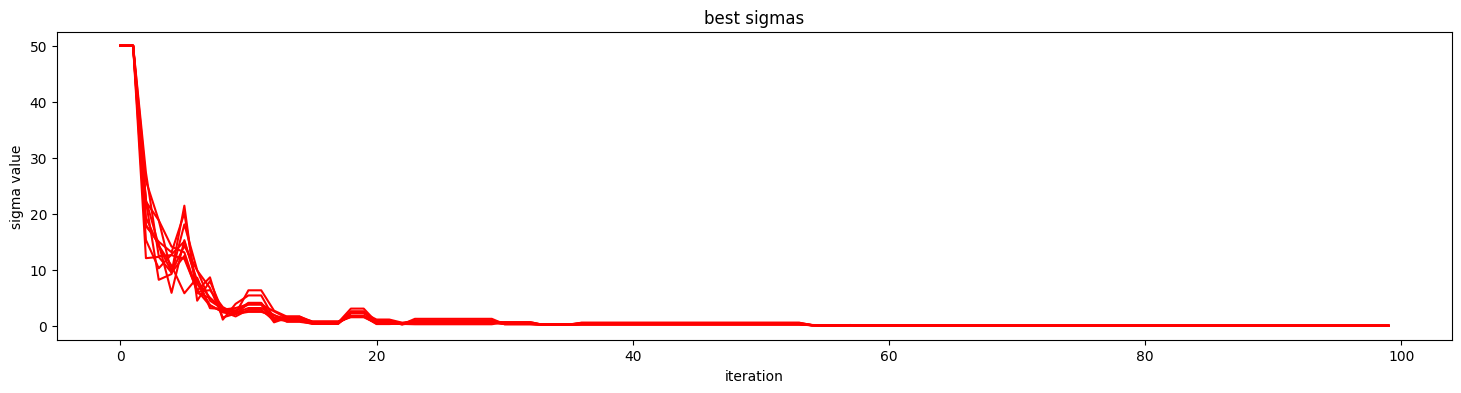

In [13]:
d = 10
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_functions.F6, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### DziaĹanie strategii ewolucyjnej dla funkcji Griewanka F8

Iteration 0000 : best score = -2.17208936, mean score = -7.57939208.
Iteration 0010 : best score = -0.49745184, mean score = -1.04710224.
Iteration 0020 : best score = -0.03644439, mean score = -0.37114151.
Iteration 0030 : best score = -0.00016239, mean score = -0.00089442.
Iteration 0040 : best score = -0.00000047, mean score = -0.00000268.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = 0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = 0.00000000, mean score = 0.00000000.


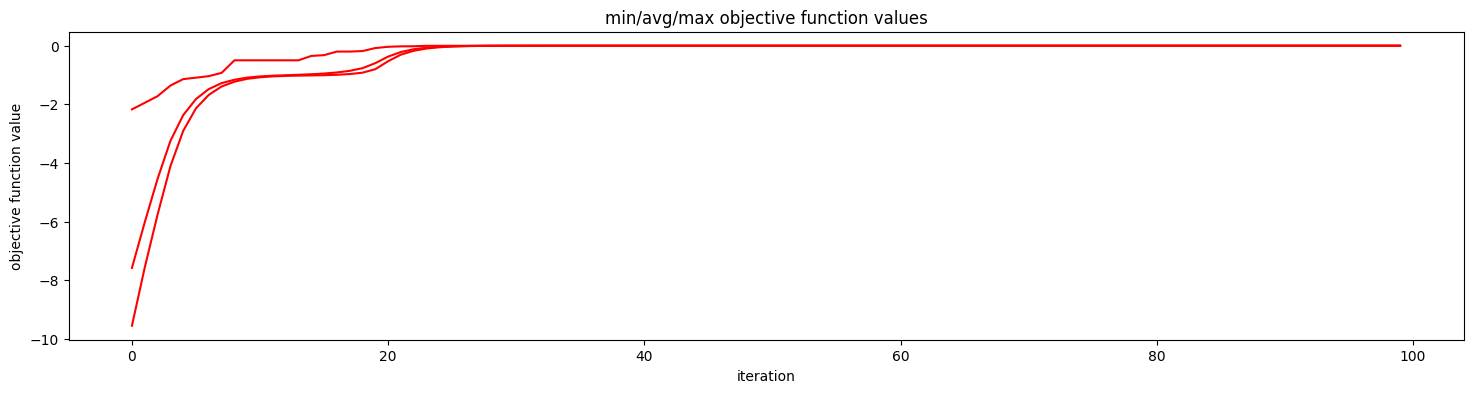

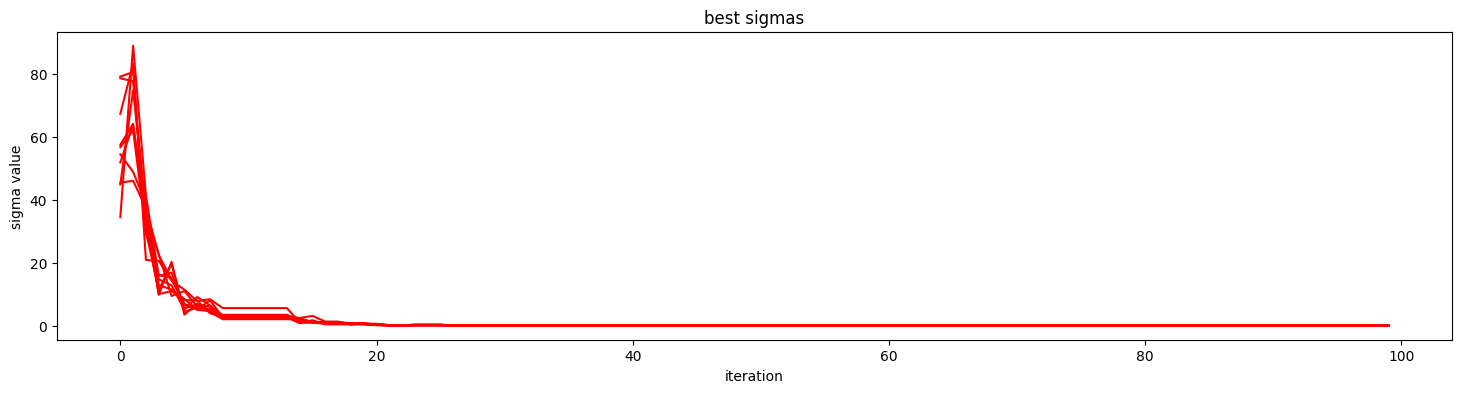

In [14]:
d = 10
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_functions.F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()